In [1]:
import torch
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer, BartModel, BartTokenizer, BartConfig, T5Model, T5Tokenizer
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


In [2]:
import transformers

In [7]:
T5Tokenizer.from_pretrained("t5-small").vocab_size

32100

In [10]:
transformers.T5Config(
    d_model=128,
    d_kv=32,
    d_ff=256,
    num_layers=6,
    num_heads=4
).save_pretrained("t5-tiny-6L-4H")

In [1]:
from datasets import load_dataset

In [13]:
!export TOKENIZERS_PARALLELISM=false

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


In [3]:
dataset = load_dataset("glue", "rte")

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/697k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /home/kzhao/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# model_name = "facebook/bart-large"
model_name = "t5-large"
# model_name = "t5-base"
if "bart" in model_name.lower():
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartModel.from_pretrained(model_name).to(device)
elif "t5" in model_name.lower():
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    tokenizer.mask_token = "<extra_id_0>"
#     model = T5Model.from_pretrained(model_name).to(device)
    model = transformers.T5ForConditionalGeneration.from_pretrained(model_name).to(device)
else:
    assert False

model.eval()

input_ids = torch.tensor([tokenizer.encode(f"A 41 year old person age is {tokenizer.mask_token} than a 42 year old person .", add_special_tokens=True)]).to(device)
# input_ids = torch.tensor([tokenizer.encode(f"rte sentence1: A smaller proportion of Yugoslavia’s Italians were settled in Slovenia (at the 1991 national census, some 3000 inhabitants of Slovenia declared themselves as ethnic Italians). sentence2: Slovenia has 3,000 inhabitants.", add_special_tokens=True)]).to(device)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
tokenized_text

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at t5-large and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['▁A',
 '▁41',
 '▁year',
 '▁old',
 '▁person',
 '▁age',
 '▁is',
 '<extra_id_0>',
 '▁than',
 '▁',
 'a',
 '▁42',
 '▁year',
 '▁old',
 '▁person',
 '▁',
 '.']

In [7]:
pad_id = torch.tensor([tokenizer.encode("<extra_id_0>", add_special_tokens=False)]).to(device)
with torch.no_grad():
    loss, decoder_features, decoder_cache, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids.repeat(2, 1), labels=pad_id.repeat(2, 1), output_hidden_states=True, output_attentions=True, output_norms=True)

In [20]:
norm_list = []
for el in encoder_norms:
    norm_list.append(el[1])

norm_tensor = torch.stack(norm_list, dim=1)
# num_layers, num_heads, seq_len, _ = norm_tensor.size()
# assert num_layers == model.config.num_hidden_layers and num_heads == model.config.num_attention_heads and seq_len == _
# norm_tensor = norm_tensor.reshape(num_layers, num_heads, seq_len * seq_len).permute(1, 0, 2).contiguous()
norm_tensor.size()

torch.Size([2, 24, 16, 17, 17])

In [17]:
encoder_norms[2][1].size()

torch.Size([2, 16, 17, 17])

In [6]:
loss

tensor(0., device='cuda:0')

In [14]:
pad_id = torch.tensor([tokenizer.encode(tokenizer.pad_token, add_special_tokens=False)]).to(device)

In [32]:
with torch.no_grad():
#     last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)
#     decoder_features, decoder_states, decoder_attns, encoder_last_state, encoder_states, encoder_attns, norms = model(input_ids=input_ids.repeat(2, 1), output_hidden_states=True, output_attentions=True, output_norms=True)    
    decoder_features, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)  # BART
#     decoder_features, decoder_cache, decoder_states, decoder_attns, decoder_self_norms, decoder_cross_norms, encoder_last_state, encoder_states, encoder_attns, encoder_norms = model(input_ids=input_ids, decoder_input_ids=pad_id, output_hidden_states=True, output_attentions=True, output_norms=True)  # T5

In [9]:
norms = encoder_norms
num_heads = model.config.num_attention_heads
num_layers = model.config.num_hidden_layers
fig = plt.figure()
fig.set_figheight(180)
fig.set_figwidth(120)
for layer in tqdm(range(num_layers)):
    for head in range(num_heads):
        ax = plt.subplot(num_layers, num_heads, num_heads * layer + head + 1)
        real_layer = layer
        afx_norm = norms[real_layer][1]  # bart decoder-self, bart cross, t5 all
        norm = afx_norm[0][head].cpu().numpy()

        plt.imshow(norm, cmap=sns.color_palette("Reds", as_cmap=True))
        ax.set_xticks(np.arange(len(tokenized_text)))
        ax.set_yticks(np.arange(len(tokenized_text)))

        ax.set_xticklabels(tokenized_text)
        ax.set_yticklabels(tokenized_text)

        ax.title.set_text(f"Layer {layer} Head {head}")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
#     time.sleep(30)

plt.savefig(f"t5-encoder-self-attention_1-16.png", bbox_inches="tight")
plt.close(fig)
# plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

In [14]:
norms = decoder_cross_norms
num_heads = model.config.num_attention_heads
num_layers = model.config.num_hidden_layers
fig = plt.figure()
fig.set_figheight(40)
fig.set_figwidth(120)
for layer in tqdm(range(num_layers)):
    for head in range(num_heads):
        ax = plt.subplot(num_layers, num_heads, num_heads * layer + head + 1)
        real_layer = layer
        afx_norm = norms[real_layer][1]  # bart decoder-self, bart cross, t5 all
        norm = afx_norm[0][head].cpu().numpy()

        plt.imshow(norm, cmap=sns.color_palette("Reds", as_cmap=True))
        ax.set_xticks(np.arange(len(tokenized_text)))
        ax.set_yticks(np.arange(1))

        ax.set_xticklabels(tokenized_text)
        ax.set_yticklabels(["<pad>"])

        ax.title.set_text(f"Layer {layer} Head {head}")

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
#     time.sleep(30)

plt.savefig(f"t5-decoder-cross-attention_1-16.png", bbox_inches="tight")
plt.close(fig)
# plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

In [31]:
decoder_norms_list = []
for layer in range(num_layers):
    decoder_norms_list.append(decoder_self_norms[layer][1])
    
decoder_norms_tensor = torch.stack(decoder_norms_list).squeeze(-1).squeeze(-1).squeeze(1)

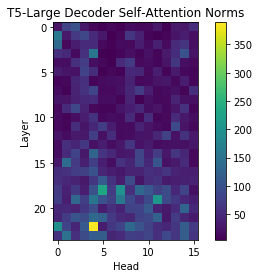

In [36]:
plt.title("T5-Large Decoder Self-Attention Norms")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.imshow(decoder_norms_tensor.cpu())
plt.colorbar()
plt.savefig(f"t5-decoder-self-attention_1-16.png", bbox_inches="tight")

In [12]:
plt.rcParams["figure.dpi"] = 240

  0%|          | 0/3 [00:00<?, ?it/s]

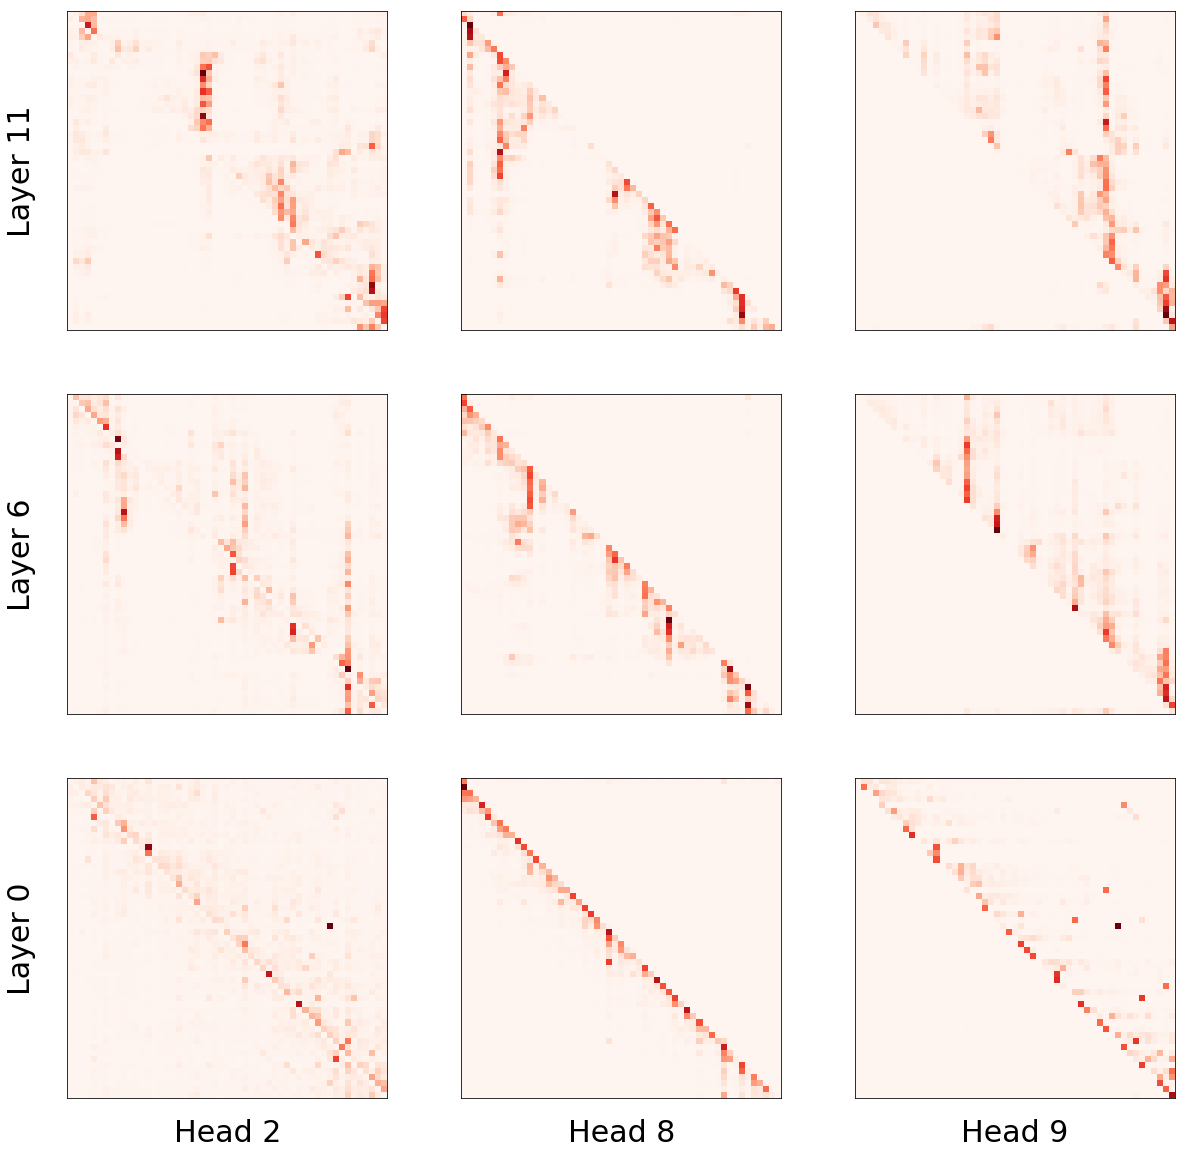

In [5]:
# def getH(head):
#     assert 0 <= head < 3
#     if head < 2:
#         return head + 7
#     elif head == 2:
#         return 12

def getH(head):
    assert 0 <= head < 3
    if head == 0:
        return 2  # 6
    elif head == 1:
        return 8
    elif head == 2:
        return 9

# def get(layer):
#     assert 0 <= layer < 3
#     if layer == 0:
#         return 10
#     elif layer == 1:
#         return 5
#     elif layer == 2:
#         return 0
    
def get(layer):
    assert 0 <= layer < 3
    if layer == 0:
        return 11
    elif layer == 1:
        return 6
    elif layer == 2:
        return 0  # 1

norms = encoder_norms
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
x_axs = [fig.add_subplot(1, 3, i, label=f"Head {getH(i - 1)}") for i in range(1, 4)]
y_axs = [fig.add_subplot(3, 1, i, label="asf") for i in range(1, 4)]

for x_ax in x_axs:
    x_ax.spines['top'].set_color('none')
    x_ax.spines['bottom'].set_color('none')
    x_ax.spines['left'].set_color('none')
    x_ax.spines['right'].set_color('none')
    x_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

for y_ax in y_axs:
    y_ax.spines['top'].set_color('none')
    y_ax.spines['bottom'].set_color('none')
    y_ax.spines['left'].set_color('none')
    y_ax.spines['right'].set_color('none')
    y_ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

for layer in tqdm(range(3)):
    for head in range(3):
        axt = fig.add_subplot(3, 3, 3 * layer + head + 1)
        afx_norm = norms[get(layer)][1]  # bart all, t5 all
        norm = afx_norm[0][getH(head)].cpu().numpy()

#         axt.imshow(norm, cmap="hot")
        axt.imshow(norm, cmap=sns.color_palette("Reds", as_cmap=True))
        axt.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# ax1.loglog(x, y1)
# ax2.loglog(x, y2)

# Set common labels
for i, x_ax in enumerate(x_axs):
    x_ax.set_xlabel(f"Head {getH(i)}", fontsize=30)

for i, y_ax in enumerate(y_axs):
    y_ax.set_ylabel(f"Layer {get(i)}", fontsize=30)

# plt.savefig('t5_base_alternate_heads_head_2.png', bbox_inches='tight')
# plt.close(fig)
plt.show()

In [33]:
norm_list = []
for el in encoder_norms:
    norm_list.append(el[1])

norm_tensor = torch.cat(norm_list, dim=0)
# num_layers, num_heads, seq_len, _ = norm_tensor.size()
# assert num_layers == model.config.num_hidden_layers and num_heads == model.config.num_attention_heads and seq_len == _
# norm_tensor = norm_tensor.reshape(num_layers, num_heads, seq_len * seq_len).permute(1, 0, 2).contiguous()
norm_tensor.size()

torch.Size([12, 16, 17, 17])

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
def compute_specialization_metric(encoder_norms):
    """
    Args:
        encoder_norms - Attention norms.
                        Tensor of size (num_layers, num_heads, seq_len, seq_len)
    """
    
    num_layers, num_heads, seq_len, seq_len2 = encoder_norms.size()
    assert seq_len == seq_len2
    encoder_norms = encoder_norms.permute(1, 0, 2, 3)  # flip layer dimension with head dimension
    encoder_norms = F.normalize(encoder_norms.flatten(2).contiguous(), p=1.0, dim=-1)  # divide each attention norm pattern by its mean
    # encoder_norms now has a size of (num_heads, num_layers, seq_len * seq_len)

    head_variances = []
    for single_head_norms in encoder_norms:
        single_head_distances = F.pdist(single_head_norms, p=1)  # pairwise L1 distances
        head_variances.append(torch.mean(single_head_distances))

    single_head_var = torch.stack(head_variances).mean()
    all_head_var = torch.mean(
        F.pdist(encoder_norms.flatten(start_dim=0, end_dim=1).contiguous(), p=1
    )).mean()  # pairwise distances between all attention norm patterns
    
#     head_variances = []
#     for single_head_norms in encoder_norms:
#         single_head_distances = F.pdist(single_head_norms, p=1)  # pairwise L1 distances
#         head_variances.append(torch.var(single_head_distances, unbiased=True))

#     single_head_var = torch.stack(head_variances).mean()
#     all_head_var = torch.var(
#         F.pdist(encoder_norms.flatten(start_dim=0, end_dim=1).contiguous(), p=1
#     ), unbiased=True).mean()  # pairwise distances between all attention norm patterns
    
    return single_head_var.item() / all_head_var.item()

In [34]:
compute_specialization_metric(norm_tensor)

1.0006509541880777

Mean: 0.0


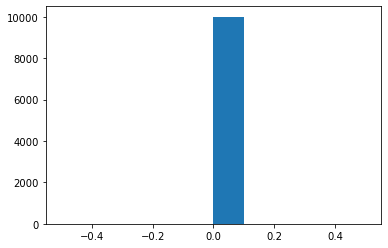

In [10]:
metrics = []
for i in range(10000):
#     encoder_norms = torch.rand(6, 4, 20, 20)
#     encoder_norms = torch.rand(1, 4, 20, 20).expand(6, 4, 20, 20)

    metrics.append(compute_specialization_metric(encoder_norms))
    
print(f"Mean: {np.mean(metrics)}")
plt.hist(metrics)
plt.show()

In [144]:
metrics = []
for i in range(5000):
    norm_tensor = torch.rand_like(norm_tensor)

    head_var = []
    for head in range(num_heads):
    #     head_distances = F.pdist(norm_tensor[head], p=1)  # pairwise distances
        head_distances = F.pdist(norm_tensor[head], p=1.0, dim=-1), p=1)
        head_var.append(torch.var(head_distances, unbiased=True))

    var_by_head = torch.stack(head_var).mean().item()
    var_all = torch.var(F.pdist(F.normalize(norm_tensor.flatten(start_dim=0, end_dim=1).contiguous(), p=1.0, dim=-1), p=1), unbiased=True).mean().item()
    metric = var_by_head / var_all
    metrics.append(metric)

(array([  20.,  146.,  617., 1243., 1353.,  969.,  467.,  144.,   35.,
           6.]),
 array([0.6036007 , 0.66992307, 0.73624545, 0.80256782, 0.86889019,
        0.93521256, 1.00153493, 1.0678573 , 1.13417967, 1.20050204,
        1.26682442]),
 <a list of 10 Patch objects>)

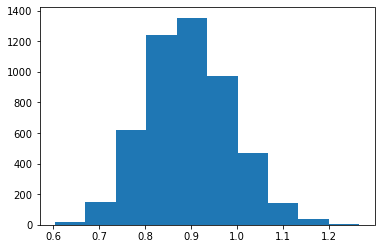

In [150]:
plt.hist(metrics)

In [145]:
np.mean(metrics)

0.8955757816967355

In [146]:
np.std(metrics)

0.09258396656428546

In [114]:
var_by_head

0.0

In [115]:
var_all

0.029955586418509483

In [77]:
var_by_head

tensor(19402692., device='cuda:0')

In [78]:
var_all

tensor(26087408., device='cuda:0')

In [ ]:
- L1 distance between attention patterns for all layers for every head
1. Normalize attention norms (somehow)
    1. Divide each attention norm by an average value of this attention norm
2. Compute all paiwise distances between the attention norms for every layer within each head
3. Compute variance between them
4. Compute mean over all heads
5. Compare BART and T5
6. Do the same, but for all paiwise distances of all heads and layers (no step 4 then)